In [1]:
import math
import copy
import numpy as np 
import statistics
import matplotlib.pyplot as plt

In [2]:
class Node:
    def __init__(self, label):
        self.label = label
        self.children = dict()

    def isLeaf(self):
        return len(self.children) == 0

In [3]:
def get_total(data):
    total = 0.0

    for row in data:
        total += row['weights']
    
    return total

In [4]:
def set_subset(data, attribute, val):
    sub_data = []

    for row in data:
        if row[attribute] == val:
            sub_data.append(row)

    return sub_data

In [5]:
def set_label(row, dt):
    new_dt = dt

    while not new_dt.isLeaf():
        curr_attr = new_dt.label
        attr_val = row[curr_attr]
        new_dt = new_dt.children[attr_val]

    return new_dt.label

In [6]:
def entropy(data):
    
    if len(data) == 0:
        return 0
    
    counts = dict()

    for row in data:
        label = row['y']
        if label not in counts:
            counts[label] = 0.0
            
        counts[label] += row['weights']

    entropy = 0.0
    total = get_total(data)
    for (label, count) in counts.items():
        p = count / total
        entropy += -p * math.log2(p)

    return entropy

def gini_index(data):
    if len(data) == 0:
        return 0
    
    counts = dict()

    for row in data:
        label = row['y']
        if label not in counts:
            counts[label] = 0.0
        counts[label] += row['weights']

    sq_sum = 0.0
    total =  get_total(data)
    for (label, count) in counts.items():
        p = count / total
        sq_sum +=p **2

    return 1-sq_sum

def ME(data):
    if len(data) == 0:
        return 0
    
    counts = dict()

    for row in data:
        label = row['y']
        if label not in counts:
            counts[label] = 0.0
        counts[label] += row['weights']

    max_p = 0.0
    total = get_total(data)
    for (label, count) in counts.items():
        p = count / total
        max_p = max(max_p, p)

    return 1-max_p

In [7]:
def info_gain(data,gain_type,attribute, vals):
    
    measure = None
    gain = 0.0
    if gain_type == 0:
        measure=entropy(data)
           
    elif gain_type == 1:
         measure=gini_index(data)
        
    elif gain_type == 2:
         measure=ME(data)
            
    for val in vals:
        sub_set = set_subset(data, attribute, val)
        total=get_total(data)
        sub_total=get_total(sub_set)
        p = sub_total /total
        gain += p * measure
        gain_x= measure-gain
        
    return gain_x

In [8]:
def select_feature(data,gain_type, attributes):
    gain_x= dict()

    for ln, lv in attributes.items():
        gain = info_gain(data,gain_type, ln, lv)
        gain_x[ln] = gain
        max_attr=max(gain_x.keys(), key=lambda key: gain_x[key])

    return max_attr

In [9]:
def majority_label(data):
    
    counts = dict()
    for row in data:
        label = row['y']
        
        if label not in counts:
            counts[label] = 0.0
            
        counts[label] += row['weights']
        
    common_label=max(counts.keys(), key=lambda key: counts[key])

    return common_label

In [10]:
def ID3(data,gain_type, attributes, labels, max_depth,depth):
    
    if (len(attributes) == 0) or depth==max_depth:
        label = majority_label(data)
        
        return Node(label)
    
    if (len(labels) == 1):
        label = labels.pop()
        
        return Node(label)

    #recursion
    max_attr = select_feature(data,gain_type,attributes)
    root = Node(max_attr)
    

    # split into subsets
    for v in attributes[max_attr]:
        sub_set = set_subset(data, max_attr, v)

        if len(sub_set) == 0:
            label = majority_label(data)
            root.children[v] = Node(label)
            
        else:
            
            sub_attributes = copy.deepcopy(attributes)
            sub_attributes.pop(max_attr)

            # update subset labels set
            sub_labels = set()
            for row in sub_set:
                sub_label = row['y']
                if  sub_labels not in sub_labels:
                    sub_labels.add(sub_label)

            # recursion
            root.children[v] = ID3(sub_set, gain_type,sub_attributes, sub_labels, max_depth, depth+1)

    return root

In [11]:
def cls(data, gain_type,attributes, labels,max_depth,depth,T):
    
    DT=[]
    alphas=[]
    
    for t in range(0, T):
        dt= ID3(data, gain_type,attributes, labels, max_depth,depth)
        DT.append(dt)
        # votes
        error = error_weight(data,dt)

        alpha = 0.5 * math.log((1-error)/error)
        alphas.append(alpha)


         # weights
        norm = 0.0
        for row in data:
                label = set_label(row,dt)

                if label != row['y']:
                    w_new = row['weights'] * math.exp(alpha)
                else:
                    w_new = row['weights'] * math.exp(-alpha)

                row['weights'] = w_new
                norm += w_new

            # normalize weights
        for row in data:
            row['weights'] /= norm

    return DT, alphas

In [12]:
def prediction(data, DT, alphas):
    
    h_rate = 0

    for row in data:
        pred = 0.0
        
        for dt,alpha in zip(DT,alphas):
            label = set_label(row,dt)
            label = 1 if label == 'yes' else -1
            pred += label * alpha

        if row['y'] == 'yes' and pred > 0:
            h_rate += 1
        if row['y'] == 'no' and pred < 0:
            h_rate += 1
    
    return h_rate/float(len(data))

In [13]:
attributes = {'age': [0, 1], 
        'job': ['admin.', 'unknown', 'unemployed', 'management', 'housemaid', 'entrepreneur', 'student', 'blue-collar', 'self-employed', 'retired', 'technician', 'services'], 
        'marital': ['married','divorced','single'], 
        'education': ['unknown', 'secondary', 'primary', 'tertiary'],
        'default': ['yes', 'no'],
        'balance': [0, 1], 
        'housing': ['yes', 'no'],
        'loan': ['yes', 'no'],
        'contact': ['unknown', 'telephone', 'cellular'],
        'day': [0, 1],  
        'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
        'duration': [0, 1],
        'campaign': [0, 1], 
        'pdays': [0, 1], 
        'previous': [0, 1], 
        'poutcome': ['unknown', 'other', 'failure', 'success']}

In [14]:
if __name__ == '__main__':
    
    columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
    labels = {'yes', 'no'}
    numeric_attrs = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [15]:
# read training data
train_data=[]
with open('train.csv', 'r') as f:
    for line in f:
        example = dict()
        terms = line.strip().split(',')
        for i in range(len(terms)):
            attrName = columns[i]
            example[attrName] = terms[i]
        
        train_data.append(example)

In [16]:
# read test data
test_data=[]
with open('test.csv', 'r') as f:
    for line in f:
        example = dict()
        terms = line.strip().split(',')
        for i in range(len(terms)):
            attrName = columns[i]
            example[attrName] = terms[i]
        
        test_data.append(example)

In [17]:
#convert numeric variable to binary variable
medians = {'age': 0.0,'balance': 0.0,'day': 0.0,'duration': 0.0,'campaign': 0.0,'pdays': 0.0,'previous': 0.0}
 
for key in medians.keys():
    vals = []
    for row in train_data:
        vals.append(float(row[key]))
    medians[key] = statistics.median(vals)


In [18]:
#if >median, 1 else 0
for key, value in medians.items():
    for row in train_data:
        val = float(row[key])
        row[key] = 1 if val > value else 0

    for row in test_data:
        val = float(row[key])
        row[key] = 1 if val > value else 0

In [19]:
#initialize the weight
train_size=float(len(train_data))
test_size=float(len(test_data))
for row in train_data:
    row['weights'] = 1/train_size

for row in test_data:
    row['weights'] = 1/test_size
    

In [20]:
def update_weight(data):
    update_w = 1/float(len(data))
    for row in data:
        row['weights'] = update_w

In [21]:
def error_weight(data, dt):
    err = 0.0

    for row in data:
        label =set_label(row, dt)
        if label != row['y']:
            err += row['weights']

    return err

In [22]:
def ada_error(train_data,test_data,gain_type, attributes, labels,max_depth,depth,T):
    
    errors_train = []
    errors_test = []


    for t in range(0, T):
       
        dt= ID3(train_data,gain_type, attributes, labels, max_depth, depth)

        # calculate votes
        err_train = error_weight(train_data, dt)
        err_test = error_weight(test_data, dt)
        errors_train.append(err_train)
        errors_test.append(err_test)
    
        
        alpha = 0.5 * math.log((1-err_train)/err_train)

        # update weights
        norm = 0.0
        for row in train_data:
            label = set_label(row, dt)
            
            if label != row['y']:
                w_new = row['weights'] * math.exp(alpha)
            else:
                w_new = row['weights'] * math.exp(-alpha)

            row['weights'] = w_new
            norm += w_new

        # normalize weights
        for row in train_data:
            row['weights'] /= norm

    return errors_train, errors_test

In [23]:
e_t, e_r = ada_error(train_data,test_data,0,attributes, labels,1,0, 100)

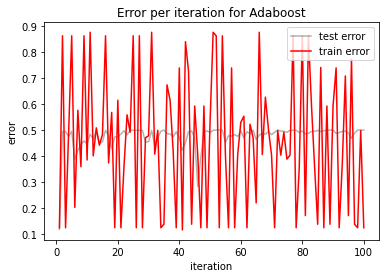

In [24]:
t = [i+1 for i in range(0,100)]
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(t,e_t, label='test error', c='black', alpha=0.3)
ax.plot(t,e_r, label='train error', c='red')
ax.legend()
ax.set_title("Error per iteration for Adaboost")
ax.set_xlabel('iteration')
ax.set_ylabel('error')

plt.show()

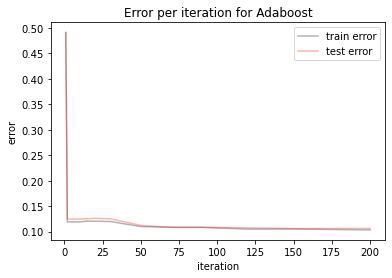

In [27]:
train_T=[]
test_T=[]
for T in [1,2,3,4,5,6,8,10,15,20,30,50,70,90,120,150,200]:
    trees, alphas = cls(train_data,0, attributes, labels, 1,0,T)
    h_train = prediction(train_data, trees, alphas)
    h_test = prediction(test_data, trees, alphas)
    h_x=1-h_train
    h_y=1-h_test
    train_T.append(h_x)
    test_T.append(h_y)
    update_weight(train_data)
x1=[x for x in [1,2,3,4,5,6,8,10,15,20,30,50,70,90,120,150,200] ]
y1=train_T
y2=test_T
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(x1,y1, label='train error', c='black', alpha=0.3)
ax.plot(x1,y2, label='test error', c='red', alpha=0.3)
ax.legend()
ax.set_title("Error per iteration for Adaboost")
ax.set_xlabel('iteration')
ax.set_ylabel('error')

plt.show()

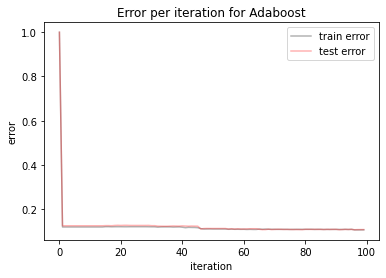

In [98]:
train_T=[]
test_T=[]
for T in range(100):
    trees, alphas = cls(train_data,0, attributes, labels, 1,0,T)
    h_train = prediction(train_data, trees, alphas)
    h_test = prediction(test_data, trees, alphas)
    h_x=1-h_train
    h_y=1-h_test
    train_T.append(h_x)
    test_T.append(h_y)
    update_weight(train_data)
x1=[x for x in range(100) ]
y1=train_T
y2=test_T
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(x1,y1, label='train error', c='black', alpha=0.3)
ax.plot(x1,y2, label='test error', c='red', alpha=0.3)
ax.legend()
ax.set_title("Error per iteration for Adaboost")
ax.set_xlabel('iteration')
ax.set_ylabel('error')

plt.show()